In [15]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *
import      configparser
inputs = configparser.ConfigParser()

#path dove stanno i dati del fit
spectra_path =   '../BRILLOUIN/TDP43/ARS_13_02/'
spectra_filename    =   'ARS_13_02'
analysis_dir     =   'analysis_delta_trf'
now_path         =   spectra_path+analysis_dir+'/'
with open(now_path+'config.ini', 'r') as f:
    inputs.read_file(f)
### recupero info su dimensionalità
n_rows    =     inputs.getint('I/O', 'n_rows')
n_cols    =     inputs.getint('I/O', 'n_cols')
###
matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)

Ho inizializzato una matrice 89x85, per un totale di 7565 spettri


In [16]:

#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)

x = np.load(now_path+'x.npy', allow_pickle = True)
y = np.load(now_path+'y.npy', allow_pickle = True)

count = 0
for ii in range(n_rows):
    for jj in range (n_cols):
        matrix[ii][jj].Recover_VIPA(x_VIPA, y_VIPA)
        matrix[ii][jj].Recover_Spectrum(x[count],y[count])    
        count+=1
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)
        
if count != (n_rows*n_cols): raise ValueError('Incompatibile')
print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [17]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni parametri fit ({})".format(len(boni), len(lines)))
if (len(boni) != len(costi)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni costo fit ({})".format(len(boni), len(costi)))
if (len(boni) != len(y_fits)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e y fit ({})".format(len(boni), len(y_fits)))


for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')




Ok ho recuperato le informazioni del Fit Markoviano


Completata Parameter_Map per Omega
Ho trovato 15 elementi saturati


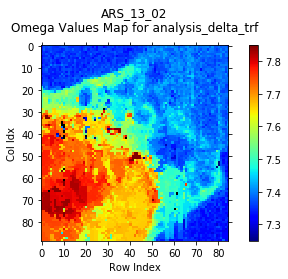

Completata Parameter_Map per Omega
Ho trovato 15 elementi saturati


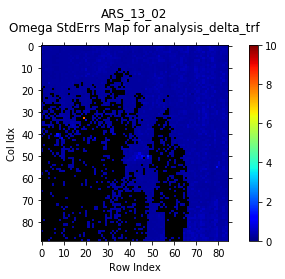

Completata Parameter_Map per Gamma
Ho trovato 15 elementi saturati


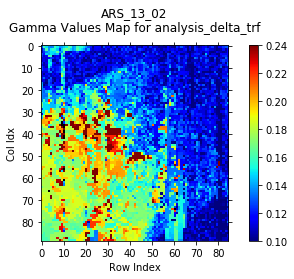

Completata Parameter_Map per Gamma
Ho trovato 15 elementi saturati


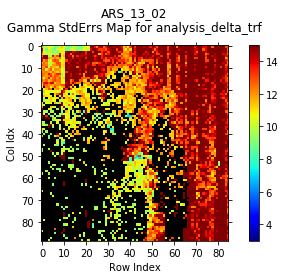

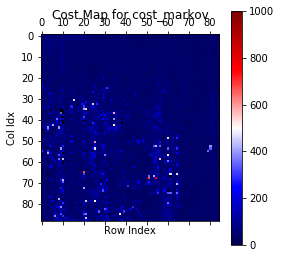

In [18]:
#MAPPE
omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.25, 7.85, analysis_dir, spectra_filename, fig = 'omega_markov_map', path=now_path)
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,10, analysis_dir, spectra_filename ,fig = 'Delta_omega_markov_map', path=now_path, Deltas = True)
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.24,analysis_dir, spectra_filename ,fig = 'Gamma_markov_map', path=now_path)
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 3, 15, analysis_dir, spectra_filename, fig = 'Delta_Gamma_markov_map', path=now_path, Deltas = True)
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)

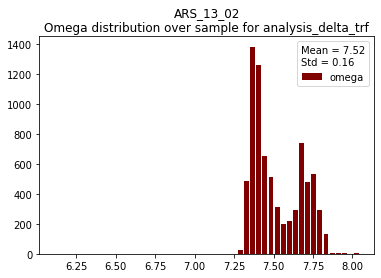

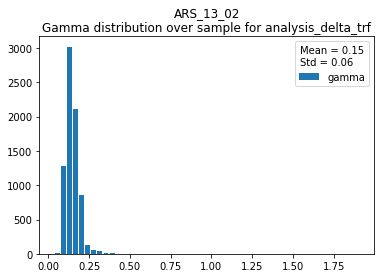

In [19]:
#HISTOGRAMs - MARKOV
markov_Omegas = np.array([matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
markov_Gammas =  np.array([matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])


plt.figure()
plt.title('{}\nOmega distribution over sample for {}'.format(spectra_filename, analysis_dir), pad = 5.)
_ = plt.hist(markov_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(markov_Omegas), np.std(markov_Omegas)))
plt.savefig(now_path+'Omega_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('{}\nGamma distribution over sample for {}'.format(spectra_filename, analysis_dir), pad = 5.)
_ = plt.hist(markov_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(markov_Gammas), np.std(markov_Gammas)))
plt.savefig(now_path+'Gamma_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()


In [20]:
#Parametri di Interesse per analisi
markov_too_bad = ()
markov_too_good  = ()
markov_omega_too_high =  ()
markov_gamma_too_bad = ()

markov_omega_max = np.mean(markov_Omegas)+3*np.std(markov_Omegas)
markov_gamma_max = np.mean(markov_Gammas)+3*np.std(markov_Gammas)
cost_max = 1000
cost_min = 50


markov_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'markov')
markov_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'markov')
markov_omega_too_high = Whose_Param_Too_High('Omega', markov_omega_max, 'markov', matrix, boni)
markov_gamma_too_high = Whose_Param_Too_High('Gamma', markov_gamma_max, 'markov', matrix, boni)


#aggiunte 
markov_too_offset = ()
percentage_gamma = 15
max_offset = 30
markov_almost_height = ()

for (ii,jj) in boni:
    if matrix[ii][jj].Markov_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Markov_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        markov_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Markov_Fit_Params['offset'].values[0] > max_offset:
        markov_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        markov_almost_height += ((ii,jj),)


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(markov_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(markov_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(markov_omega_too_high), markov_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(markov_gamma_too_high), markov_gamma_max))

print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(markov_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(markov_too_offset), max_offset))





I found 0 bad elements out of 7550

I found 5091 good elements out of 7550





Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/ARS_13_02/analysis_delta_trf/ :

0 elementi con chi quadro > 1000 
5091 elementi con chi quadro < 50 

3 elementi con Omega > Omega max 7.99
66 elementi con Gamma > Gamma max 0.32

1766 elementi con Gamma con errore percentuale > 15 

0 elementi con offset > 30 



(0, 0)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.013124  7.364761  0.143181        0.079073     0.051936   
StdErrs   0.016666  0.020360  0.014050        0.014661     0.015248   
Initials  0.010000  7.661468  0.100000        0.000000     0.100000   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.040687  5.455491e+03  11.842649  16.774011  0.017084   
StdErrs          0.006036  1.028179e+10  12.431938  35.832892  0.020075   
Initials         1.000000  4.546282e+03  11.962272  16.790802  0.000000   

            offset  
Values    2.000000  
StdErrs   0.748004  
Initials  0.000000  


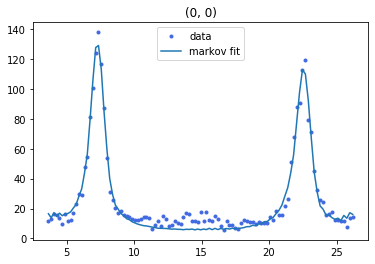

(0, 1)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.012284  7.360309  0.139268        0.086360     0.019387   
StdErrs   0.018336  0.019873  0.013533        0.009275     0.013267   
Initials  0.013124  7.364761  0.143181        0.079073     0.051936   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.008357  6.535624e+03  11.724223  16.757237  0.117067   
StdErrs          0.004489  1.316091e+10  14.764112  42.059438  0.019740   
Initials         0.040687  5.455491e+03  11.842649  16.774011  0.017084   

            offset  
Values    2.000000  
StdErrs   0.653202  
Initials  2.000000  


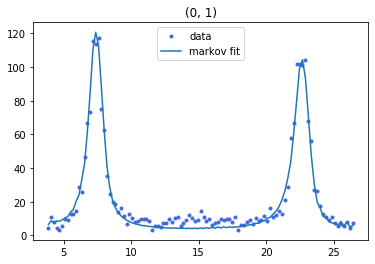

(0, 2)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.012086  7.386981  0.142756        0.086197     0.024109   
StdErrs   0.018022  0.020263  0.014002        0.010778     0.014539   
Initials  0.012284  7.360309  0.139268        0.086360     0.019387   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.010273  7.842143e+03  11.606981  16.740480  0.115715   
StdErrs          0.004927  1.448835e+10  15.275706  41.772831  0.020038   
Initials         0.008357  6.535624e+03  11.724223  16.757237  0.117067   

            offset  
Values    2.000000  
StdErrs   0.661746  
Initials  2.000000  


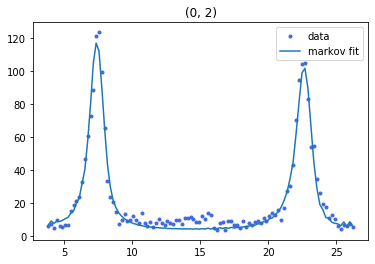

(0, 3)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.012901  7.347283  0.162965        0.489814     0.059239   
StdErrs   0.010539  0.021950  0.015332        0.024872     0.025370   
Initials  0.012086  7.386981  0.142756        0.086197     0.024109   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.032921  6.454875e+03  11.490911  16.723739  0.115877   
StdErrs          0.006051  1.585215e+10   8.528228  22.877550  0.021513   
Initials         0.010273  7.842143e+03  11.606981  16.740480  0.115715   

            offset  
Values    2.000000  
StdErrs   0.728716  
Initials  2.000000  


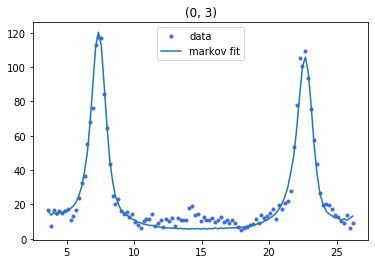

(0, 4)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.012792  7.374813  0.144838        0.502672     0.054237   
StdErrs   0.011198  0.022626  0.014300        0.019243     0.020494   
Initials  0.012901  7.347283  0.162965        0.489814     0.059239   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.035808  5.176810e+03  11.376002  16.707015  0.117696   
StdErrs          0.006748  1.126674e+10   9.457390  24.433639  0.020450   
Initials         0.032921  6.454875e+03  11.490911  16.723739  0.115877   

            offset  
Values    2.000000  
StdErrs   0.734154  
Initials  2.000000  


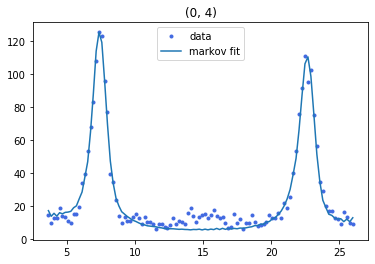

(0, 5)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.012536  7.360391  0.138735        0.536877     0.016516   
StdErrs   0.015563  0.019820  0.013664        0.005888     0.006611   
Initials  0.012792  7.374813  0.144838        0.502672     0.054237   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.012394  6.212172e+03  11.262242  16.690308  0.113968   
StdErrs          0.004663  1.371605e+10  14.100390  34.609929  0.019326   
Initials         0.035808  5.176810e+03  11.376002  16.707015  0.117696   

            offset  
Values    2.000000  
StdErrs   0.674185  
Initials  2.000000  


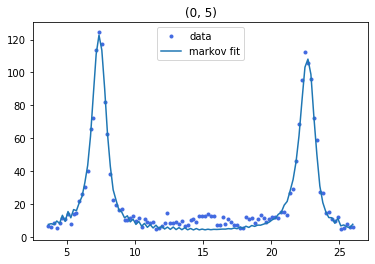

(0, 6)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.012547  7.349075  0.155422       -0.109998     0.032047   
StdErrs   0.019446  0.021485  0.014615        0.014538     0.017106   
Initials  0.012536  7.360391  0.138735        0.536877     0.016516   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.013306  7.239130e+03  11.374864  16.706999  0.115947   
StdErrs          0.005796  1.064539e+10  17.087879  43.334366  0.020745   
Initials         0.012394  6.212172e+03  11.262242  16.690308  0.113968   

            offset  
Values    2.000000  
StdErrs   0.635167  
Initials  2.000000  


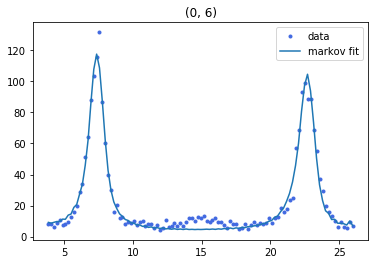

(0, 7)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.012810  7.368157  0.132789       -0.111207     0.042836   
StdErrs   0.022165  0.020605  0.013238        0.018735     0.018731   
Initials  0.012547  7.349075  0.155422       -0.109998     0.032047   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.016931  5.791318e+03  11.261116  16.690292  0.268171   
StdErrs          0.004552  1.176134e+10  18.762287  48.265500  0.019315   
Initials         0.013306  7.239130e+03  11.374864  16.706999  0.115947   

            offset  
Values    2.000000  
StdErrs   0.658792  
Initials  2.000000  


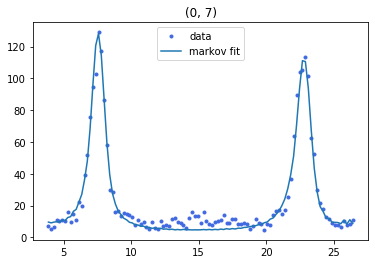

(0, 8)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.013111  7.347198  0.160793       -0.094901     0.027893   
StdErrs   0.021099  0.021338  0.014550        0.013565     0.014841   
Initials  0.012810  7.368157  0.132789       -0.111207     0.042836   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.011838  4.644637e+03  11.373727  16.706982  0.262548   
StdErrs          0.005783  9.294364e+09  16.948444  45.051245  0.020650   
Initials         0.016931  5.791318e+03  11.261116  16.690292  0.268171   

            offset  
Values    2.000000  
StdErrs   0.629968  
Initials  2.000000  


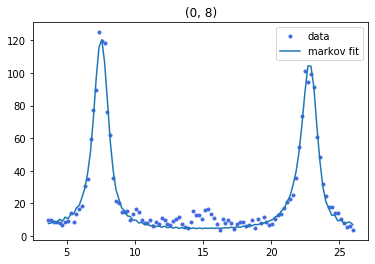

(0, 9)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.012758  7.389541  0.143214        0.239856     0.053181   
StdErrs   0.011634  0.021439  0.015633        0.009069     0.010225   
Initials  0.013111  7.347198  0.160793       -0.094901     0.027893   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.090411  3.840002e+03  11.259989  16.690275 -0.007463   
StdErrs          0.010795  5.393334e+09  10.523679  25.319953  0.021537   
Initials         0.011838  4.644637e+03  11.373727  16.706982  0.262548   

            offset  
Values    2.000000  
StdErrs   0.917911  
Initials  2.000000  


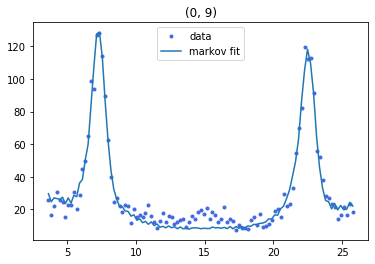

In [21]:
Plot_Elements_Spectrum(matrix, boni[:10], fit = 'markov')

In [22]:
for ii,jj in boni[:5]:
    print(matrix[ii][jj].Markov_Fit_Params.values[0])

[1.31244262e-02 7.36476093e+00 1.43181265e-01 7.90729894e-02
 5.19359432e-02 4.06866443e-02 5.45549121e+03 1.18426495e+01
 1.67740108e+01 1.70836699e-02 2.00000000e+00]
[1.22838213e-02 7.36030865e+00 1.39267887e-01 8.63600595e-02
 1.93874912e-02 8.35704883e-03 6.53562399e+03 1.17242230e+01
 1.67572367e+01 1.17067193e-01 2.00000000e+00]
[1.20858077e-02 7.38698141e+00 1.42755672e-01 8.61974669e-02
 2.41091030e-02 1.02731231e-02 7.84214334e+03 1.16069807e+01
 1.67404795e+01 1.15715059e-01 2.00000000e+00]
[1.29005141e-02 7.34728284e+00 1.62965034e-01 4.89814458e-01
 5.92386569e-02 3.29211889e-02 6.45487533e+03 1.14909109e+01
 1.67237390e+01 1.15877482e-01 2.00000000e+00]
[1.27917040e-02 7.37481343e+00 1.44838012e-01 5.02672119e-01
 5.42365491e-02 3.58079264e-02 5.17681001e+03 1.13760018e+01
 1.67070153e+01 1.17696368e-01 2.00000000e+00]


In [23]:
################ TOTALE

with open(now_path+'y_tot_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    matrix[ii][jj].Recover_y_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

Ok ho recuperato le informazioni del Fit Totale


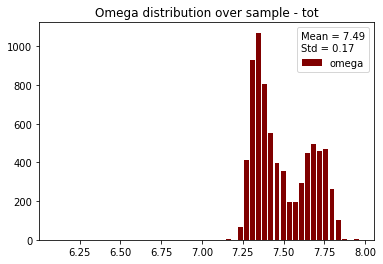

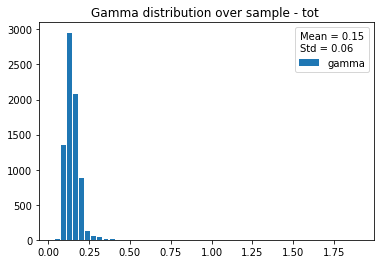

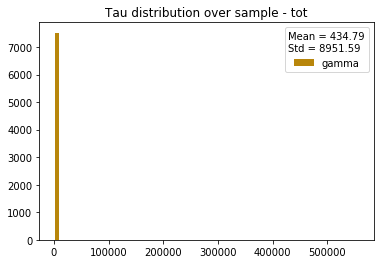

In [24]:
#HISTOGRAMs
tot_Omegas = np.array([matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
tot_Gammas =  np.array([matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])
taus       = np.array([matrix[ii][jj].Tot_Fit_Params['tau'].values[0] for (ii,jj) in boni])

plt.figure()
plt.title('Omega distribution over sample - tot')
_ = plt.hist(tot_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(tot_Omegas), np.std(tot_Omegas)))
plt.savefig(now_path+'Omega_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample - tot ')
_ = plt.hist(tot_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(tot_Gammas), np.std(tot_Gammas)))
plt.savefig(now_path+'Gamma_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Tau distribution over sample - tot')
_ = plt.hist(taus, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8, color = 'darkgoldenrod')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(taus), np.std(taus)))
plt.savefig(now_path+'tau_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()


In [25]:
#Parametri di Interesse per analisi
tot_too_bad = ()
tot_too_good  = ()
tot_omega_too_high =  ()
tot_gamma_too_bad = ()
tau_not_bad = []

tot_omega_max = np.mean(tot_Omegas)+3*np.std(tot_Omegas)
tot_omega_min = np.mean(tot_Omegas)-3*np.std(tot_Omegas)

tot_gamma_max = np.mean(tot_Gammas)+5*np.std(tot_Gammas)
cost_max = 1000
cost_min = 50


tot_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'tot')
tot_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'tot')
tot_omega_too_high = Whose_Param_Too_High('Omega', tot_omega_max, 'tot', matrix, boni)
tot_gamma_too_high = Whose_Param_Too_High('Gamma', tot_gamma_max, 'tot', matrix, boni)
tot_omega_too_low =  Whose_Param_Too_Low('Omega', tot_omega_min,'tot', matrix, boni)

#aggiunte 
omega_different_from_mark = []
gamma_different_from_mark = []

percentage_diff = 0.8
tot_too_offset = ()
percentage_gamma = 100
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    
    perc_omega = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100
    perc_gamma = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100

    if (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] > matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] < matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] - perc_gamma):
        omega_different_from_mark.append((ii,jj))
    if (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] > matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] < matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] - perc_omega):
        gamma_different_from_mark.append((ii,jj))
    if matrix[ii][jj].Tot_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Tot_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        tot_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['offset'].values[0] > max_offset:
        tot_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        tot_almost_height += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['tau']['StdErrs'] < matrix[ii][jj].Tot_Fit_Params['tau']['Values']:
        tau_not_bad.append((ii,jj))


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(tot_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(tot_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(tot_omega_too_high), tot_omega_max))
print('{} elementi con Omega < Omega min {:3.2f}'.format(len(tot_omega_too_low), tot_omega_min))

print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(tot_gamma_too_high), tot_gamma_max))


print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(tot_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(tot_too_offset), max_offset))

print('{} elementi il cui fit tot di Omega è diverso del {} percento da markoviano'.format(len(omega_different_from_mark), percentage_diff))
print('{} elementi il cui fit tot di Gamma è diverso del {} percento da markoviano'.format(len(gamma_different_from_mark), percentage_diff))
print('{} elementi il cui fit di tau non è cosi male..'.format(len(tau_not_bad)), tau_not_bad)


I found 0 bad elements out of 7550

I found 5196 good elements out of 7550





Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/ARS_13_02/analysis_delta_trf/ :

0 elementi con chi quadro > 1000 
5196 elementi con chi quadro < 50 

0 elementi con Omega > Omega max 8.01
3 elementi con Omega < Omega min 6.97
18 elementi con Gamma > Gamma max 0.43

664 elementi con Gamma con errore percentuale > 100 

0 elementi con offset > 30 

2524 elementi il cui fit tot di Omega è diverso del 0.8 percento da markoviano
0 elementi il cui fit tot di Gamma è diverso del 0.8 percento da markoviano
0 elementi il cui fit di tau non è cosi male.. []


In [26]:
Plot_Elements_Spectrum(matrix, tau_not_bad[:10], fit = 'tot')

Completata Parameter_Map per Omega
Ho trovato 15 elementi saturati


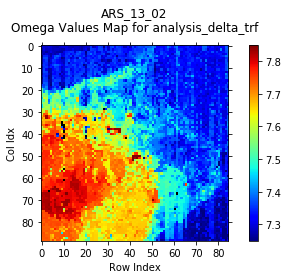

Completata Parameter_Map per Omega
Ho trovato 15 elementi saturati


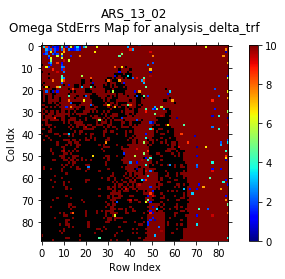

Completata Parameter_Map per Gamma
Ho trovato 15 elementi saturati


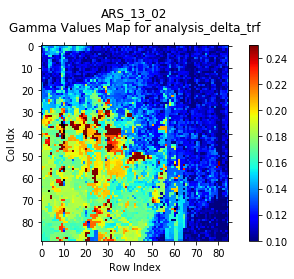

Completata Parameter_Map per Gamma
Ho trovato 15 elementi saturati


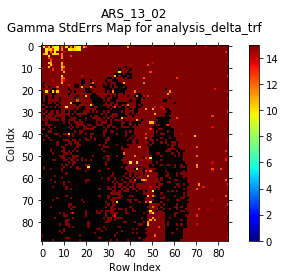

Completata Parameter_Map per tau
Ho trovato 15 elementi saturati


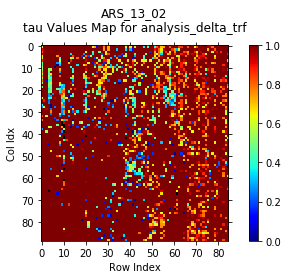

Completata Parameter_Map per tau
Ho trovato 15 elementi saturati


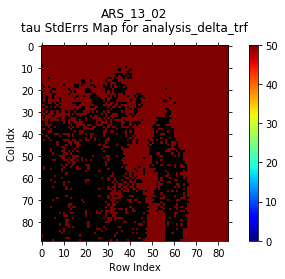

In [27]:
omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.25, 7.85, analysis_dir, spectra_filename,fig = 'omega_tot_map', path=now_path)
Delta_omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,10,analysis_dir, spectra_filename, fig = 'Delta_omega_tot_map', path=now_path, Deltas = True)
gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.25, analysis_dir, spectra_filename,fig = 'Gamma_tot_map', path=now_path)
Delta_gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0,15,analysis_dir, spectra_filename, fig = 'Delta_gamma_tot_map', path=now_path, Deltas = True)
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0., 1,analysis_dir, spectra_filename, fig = 'tau_map', path=now_path)
Delta_tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0,50,analysis_dir, spectra_filename, fig = 'Delta_tau_map', path=now_path, Deltas = True)

Completata Parameter_Map per tau
Ho trovato 15 elementi saturati


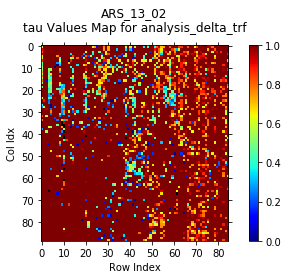

In [28]:
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0., 1,analysis_dir, spectra_filename, fig = 'tau_map', path=now_path)


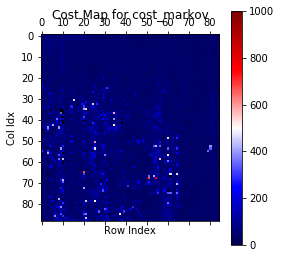

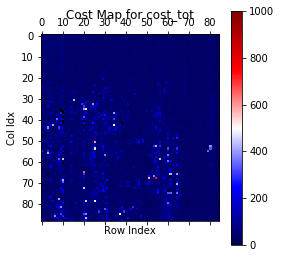

In [29]:
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)
tot_cost_map = Get_cost_map(matrix, 'tot', len(rows), len(cols), 'tot_cost_map', path = now_path)


In [30]:
for ii,jj in boni[:2]:
    matrix[ii][jj].Markov_Fit_Params.to_hdf('markov_prova.df', key = str((ii,jj)))

In [31]:
prova = []
for ii,jj in boni[:2]:
    prova.append(pd.read_hdf('markov_prova.df', str((ii,jj))))

In [32]:
prova

[                Co     Omega     Gamma  delta_position  delta_width  \
 Values    0.013124  7.364761  0.143181        0.079073     0.051936   
 StdErrs   0.016666  0.020360  0.014050        0.014661     0.015248   
 Initials  0.010000  7.661468  0.100000        0.000000     0.100000   
 
           delta_amplitude             A         mu      sigma     shift  \
 Values           0.040687  5.455491e+03  11.842649  16.774011  0.017084   
 StdErrs          0.006036  1.028179e+10  12.431938  35.832892  0.020075   
 Initials         1.000000  4.546282e+03  11.962272  16.790802  0.000000   
 
             offset  
 Values    2.000000  
 StdErrs   0.748004  
 Initials  0.000000  ,
                 Co     Omega     Gamma  delta_position  delta_width  \
 Values    0.012284  7.360309  0.139268        0.086360     0.019387   
 StdErrs   0.018336  0.019873  0.013533        0.009275     0.013267   
 Initials  0.013124  7.364761  0.143181        0.079073     0.051936   
 
           delta_amplitud